In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib

In [3]:
from sympy import (symbols, simplify)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import Lagrangian, ReferenceFrame, Point, Particle,inertia, RigidBody

In [4]:
from optibot.symbolic import lagrange, diff_to_symb, SimpLagrangesMethod
from optibot.numpy import unpack

In [5]:
from optibot.pseudospectral import (base_points, coll_points, matrix_D_bary, bary_poly, 
                                    LG_diff_end_p_fun, dynamic_error_pseudospectral, lagrangePolynomial,
                                    LG_diff_end_p_fun_cas)

In [6]:
from functools import lru_cache

In [7]:
import casadi as cas

In [8]:
init_vprinting()

### Symbolic Problem Modelling

In [9]:
def quaternion(theta, vect):
    vect = np.array(vect)
    mod = np.sqrt(np.sum(vect**2))
    vect = vect/mod
    quat = np.zeros(4)
    quat[0] = np.cos(theta/2)
    quat[1:] = np.sin(theta/2)*vect
    return quat

In [10]:
quaternion(1, [1,2,0])

array([0.87758256, 0.21440562, 0.42881124, 0.        ])

In [11]:
_q = cas.SX.sym("q", 4)

In [12]:
_W = cas.SX.zeros(3,4)
_W[0,0] = -_q[1]
_W[0,1] = _q[0]
_W[0,2] = _q[3]
_W[0,3] = -_q[2]
_W[1,0] = -_q[2]
_W[1,1] = -_q[3]
_W[1,2] = _q[0]
_W[1,3] = _q[1]
_W[2,0] = -_q[3]
_W[2,1] = _q[2]
_W[2,2] = -_q[1]
_W[2,3] = _q[0]
_W

SX(
[[(-q_1), q_0, q_3, (-q_2)], 
 [(-q_2), (-q_3), q_0, q_1], 
 [(-q_3), q_2, (-q_1), q_0]])

In [13]:
W_cas = cas.Function(
        "W",
        [_q],
        [_W,],
        ["q"],
        ["W"],
    )

In [14]:
_R = cas.SX.zeros(3,3)
_R[0,0] = _q[0]**2 + _q[1]**2 - _q[2]**2 - _q[3]**2
_R[0,1] = 2 * (_q[1]*_q[2] - _q[0]*_q[3])
_R[0,2] = 2 * (_q[1]*_q[3] + _q[0]*_q[2])
_R[1,0] = 2 * (_q[1]*_q[2] + _q[0]*_q[3])
_R[1,1] = _q[0]**2 - _q[1]**2 + _q[2]**2 - _q[3]**2
_R[1,2] = 2 * (_q[2]*_q[3] - _q[0]*_q[1])
_R[2,0] = 2 * (_q[1]*_q[3] - _q[0]*_q[2])
_R[2,1] = 2 * (_q[3]*_q[2] + _q[0]*_q[1])
_R[2,2] = _q[0]**2 - _q[1]**2 - _q[2]**2 + _q[3]**2
_R

SX(@1=2, 
[[(((sq(q_0)+sq(q_1))-sq(q_2))-sq(q_3)), (@1*((q_1*q_2)-(q_0*q_3))), (@1*((q_1*q_3)+(q_0*q_2)))], 
 [(@1*((q_1*q_2)+(q_0*q_3))), (((sq(q_0)-sq(q_1))+sq(q_2))-sq(q_3)), (@1*((q_2*q_3)-(q_0*q_1)))], 
 [(@1*((q_1*q_3)-(q_0*q_2))), (@1*((q_3*q_2)+(q_0*q_1))), (((sq(q_0)-sq(q_1))-sq(q_2))+sq(q_3))]])

In [15]:
_mod_q_sq = _q.T @ _q

In [16]:
R_cas_no_unit = cas.Function(
        "R",
        [_q],
        [1 / _mod_q_sq * _R],
        ["q"],
        ["R"],
    )

In [17]:
R_cas_no_unit(_q)

SX(@1=(((sq(q_0)+sq(q_1))+sq(q_2))+sq(q_3)), @2=2, 
[[((((sq(q_0)+sq(q_1))-sq(q_2))-sq(q_3))/@1), ((@2*((q_1*q_2)-(q_0*q_3)))/@1), ((@2*((q_1*q_3)+(q_0*q_2)))/@1)], 
 [((@2*((q_1*q_2)+(q_0*q_3)))/@1), ((((sq(q_0)-sq(q_1))+sq(q_2))-sq(q_3))/@1), ((@2*((q_2*q_3)-(q_0*q_1)))/@1)], 
 [((@2*((q_1*q_3)-(q_0*q_2)))/@1), ((@2*((q_3*q_2)+(q_0*q_1)))/@1), ((((sq(q_0)-sq(q_1))-sq(q_2))+sq(q_3))/@1)]])

In [18]:
_I_diag = cas.SX.eye(3)
_I_diag_vals = cas.SX.sym("I", 3)
_I_diag[0,0] = _I_diag_vals[0]
_I_diag[1,1] = _I_diag_vals[1]
_I_diag[2,2] = _I_diag_vals[2]

_I_diag

SX(
[[I_0, 00, 00], 
 [00, I_1, 00], 
 [00, 00, I_2]])

In [19]:
I_cas_diag = cas.Function(
        "I",
        [_I_diag_vals],
        [_I_diag],
        ["I values"],
        ["I"],
    )

In [20]:
_cross_mat = cas.SX(3,3)
_cross_mat[0,1] = -_I_diag_vals[2]
_cross_mat[0,2] = _I_diag_vals[1]
_cross_mat[1,0] = _I_diag_vals[2]
_cross_mat[1,2] = -_I_diag_vals[0]
_cross_mat[2,0] = -_I_diag_vals[1]
_cross_mat[2,1] = _I_diag_vals[0]
_cross_mat

SX(
[[00, (-I_2), I_1], 
 [I_2, 00, (-I_0)], 
 [(-I_1), I_0, 00]])

In [21]:
cross_mat_cas = cas.Function(
        "M_x",
        [_I_diag_vals],
        [_cross_mat],
        ["vector"],
        ["Cross product matrix"],
    )

In [22]:
_q_dot = cas.SX.sym("q_d", 4)

In [23]:
_omega = 2/_mod_q_sq*_W@_q_dot
_omega

SX(@1=(2/(((sq(q_0)+sq(q_1))+sq(q_2))+sq(q_3))), [(((((@1*q_0)*q_d_1)-((@1*q_1)*q_d_0))+((@1*q_3)*q_d_2))-((@1*q_2)*q_d_3)), ((((@1*q_0)*q_d_2)-(((@1*q_2)*q_d_0)+((@1*q_3)*q_d_1)))+((@1*q_1)*q_d_3)), (((((@1*q_2)*q_d_1)-((@1*q_3)*q_d_0))-((@1*q_1)*q_d_2))+((@1*q_0)*q_d_3))])

In [24]:
omega_cas = cas.Function(
        "w",
        [_q, _q_dot],
        [_omega],
        ["q", "q_d"],
        ["omega"],
    )

In [25]:
e3_x = cross_mat_cas([0,0,1])
e3 = cas.SX(3,1)
e3[2] = 1
_u = cas.SX.sym("u", 3)
_params = cas.SX.sym("param", 6)
_m, _g, _h, _Ix, _Iy, _Iz = cas.vertsplit(_params)
_I_diag_vals = _params[3:6]
_I_inv = cas.inv(I_cas_diag(_I_diag_vals))

In [26]:
_omega_d = _I_inv @ (_u + _m*_g*_h* e3_x@R_cas_no_unit(_q).T@e3 - cross_mat_cas(_omega)@I_cas_diag(_I_diag_vals).T@_omega)

In [27]:
_omega_d.shape

In [28]:
_q_d_d = 1/2*W_cas(_q_dot).T@_omega + 2*W_cas(_q).T@_omega_d

In [29]:
_q_d_d.shape

In [30]:
q_d_d_cas = cas.Function(
        "q_dot_dot",
        [_q, _q_dot, _u, _params],
        [_q_d_d],
        ["q", "q_d", "u", "params"],
        ["q_dot_dot"],
    )
q_d_d_cas.__name__ = q_d_d_cas.name()

In [31]:
q_d_d_cas([0,0,0,1], [1,1,1,1], [0,1,1], [1,1,1,1,1,1]).shape

In [42]:
def quat_to_cart(q):
    return params[2]*np.array(R_cas_no_unit(q))@np.array([0,0,1])

def quat_to_cart_arr(q_arr):
    l = q_arr.shape[0]
    res = np.zeros([l,3])
    for ii in range(l):
        res[ii,:] = quat_to_cart(q_arr[ii,:])
    return res

In [120]:
def _energ(q, qdot, params):
    [m_n, g_n, h_n, Ix, Iy,Iz] = params 
    I =I_cas_diag([Ix, Iy, Iz])
    omeg = omega_cas(q, qdot)
    r_mat = R_cas_no_unit(q)
    i_iner = r_mat @ I @r_mat.T
    t = 0.5* omeg.T @i_iner @omeg
    z = quat_to_cart(q)[2]
    v = m_n * g_n * (-z)
    return (t+v), t, v

def energy_arr(q_arr, qdot_arr, params):
    l = q_arr.shape[0]
    res = np.zeros([l,3])
    for ii in range(l):
        res[ii,:] = _energ(q_arr[ii,:], qdot_arr[ii,:], params)
    return res

In [121]:
m_n = 1
h_n = 0.5
g_n = 9.81
Ix = 1
Iy = 1
Iz = 1
params = [m_n, g_n, h_n, Ix, Iy,Iz]

In [122]:
_energ(quaternion(0.5, [1,2,0]), [1,0,0,1], params)

(DM(-2.18213), DM(2.12242), -4.304542466072277)

## Integración a las bravas

In [33]:
from optibot.schemes import expand_G

In [34]:
x_d_cas = expand_G(q_d_d_cas, 'casadi')
def embudo(x, u, p):
    sol = x_d_cas(x,u,p)
    sol = np.array(sol).flatten()
    return sol

In [35]:
x0 = np.zeros(8)
q0 = quaternion(1, [1,2,0])
x0[:4] = q0

In [36]:
x_d_cas(x0, [0,0,0], params).shape

In [37]:
embudo(x0, [0,1,1],params)

array([ 0.        ,  0.        ,  0.        ,  0.        ,  3.09995402,
       -2.38212482, -5.1531407 ,  2.18397636])

In [38]:
from optibot.schemes import (integrate_trapz, integrate_rk4, integrate_hs, interpolated_array,
                             coherent_dimensions, trapz_step, rk4_step, hs_step, vec_len)

In [95]:
x_arr = integrate_trapz(
    x_0=x0,
    u = np.zeros([20,3]),
    F = embudo,
    dt = 0.1,
    params=params
)
q_arr = x_arr[:,:4]
v_arr = x_arr[:,4:]

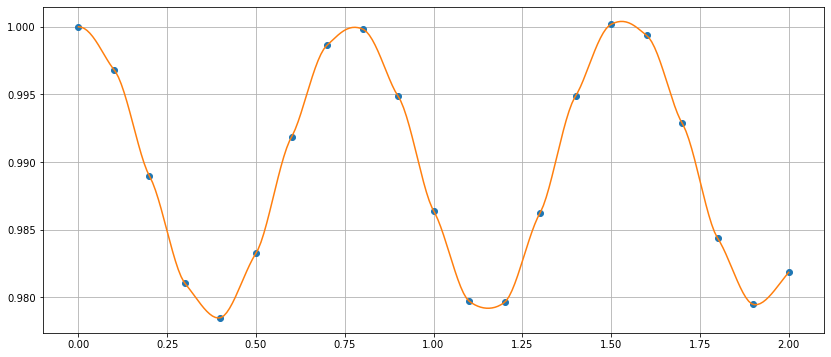

In [96]:
t_interp = np.linspace(0,2,250)
x_interp, u_interp = interpolated_array(
    x_arr,
    np.zeros([20,3]),
    0.1,
    t_interp,
    params,
    F=embudo,
    X_dot=None,
    scheme="trapz",
    u_scheme="lin",
    scheme_params={},
)
q_interp = x_interp[:,:4]
plt.figure(figsize=[14,6])
plt.plot(np.linspace(0,2,21),np.sum(q_arr**2, axis = 1), 'o' )
plt.plot(t_interp, np.sum(q_interp**2, axis = 1))
plt.grid()

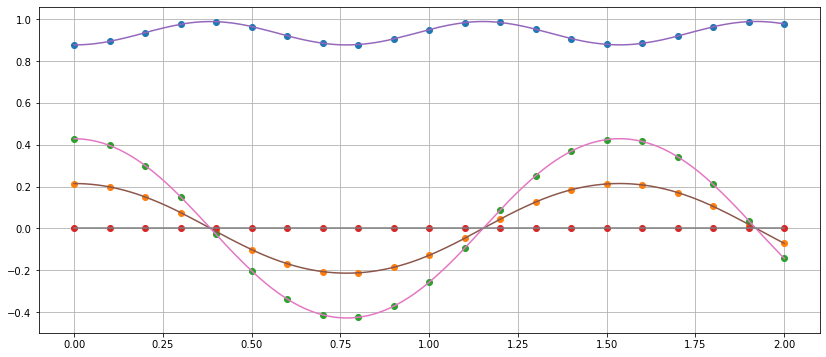

In [97]:
t_interp = np.linspace(0,2,250)
x_interp, u_interp = interpolated_array(
    x_arr,
    np.zeros([20,3]),
    0.1,
    t_interp,
    params,
    F=embudo,
    X_dot=None,
    scheme="trapz",
    u_scheme="lin",
    scheme_params={},
)
q_interp = x_interp[:,:4]
plt.figure(figsize=[14,6])
plt.plot(np.linspace(0,2,21),q_arr, 'o' )
plt.plot(t_interp, q_interp)
plt.grid()

In [98]:
%matplotlib inline

/var/folders/zr/77h_h1jj5c3bsmnltbw6p0s40000gq/T/ipykernel_8923/681798169.py:16: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  res[ii,:] = _energ(q_arr[ii,:], qdot_arr[ii,:], params)


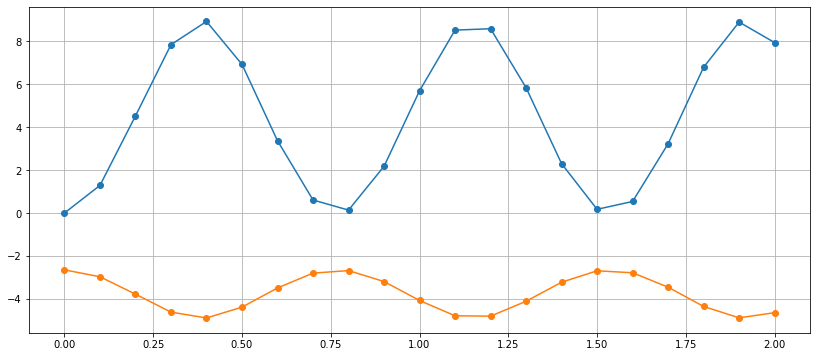

In [124]:
plt.figure(figsize=[14,6])
plt.plot(np.linspace(0,2,21),energy_arr(q_arr, v_arr, params)[:,1:], marker = 'o')
plt.grid()

In [ ]:
plt.figure(figsize=[14,6])
cart_arr = quat_to_cart_arr(q_arr)
plt.plot(np.linspace(0,2,21),cart_arr, marker = 'o')
plt.grid()

In [46]:
%matplotlib notebook

<IPython.core.display.Javascript object>


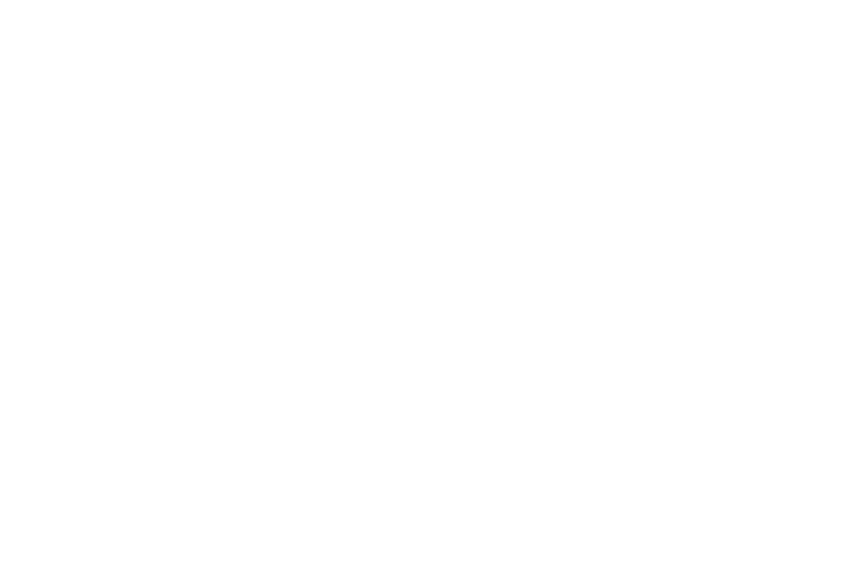

In [47]:
ax = plt.axes(projection='3d')

ax.plot3D(cart_arr[:,0], cart_arr[:,1], cart_arr[:,2], 'gray', marker = 'o')

In [48]:
%matplotlib inline

In [49]:
x_arr = integrate_rk4(
    x_0=x0,
    u = np.zeros([20,3]),
    F = embudo,
    dt = 0.1,
    params=params
)
q_arr = x_arr[:,:4]
v_arr = x_arr[:,4:]

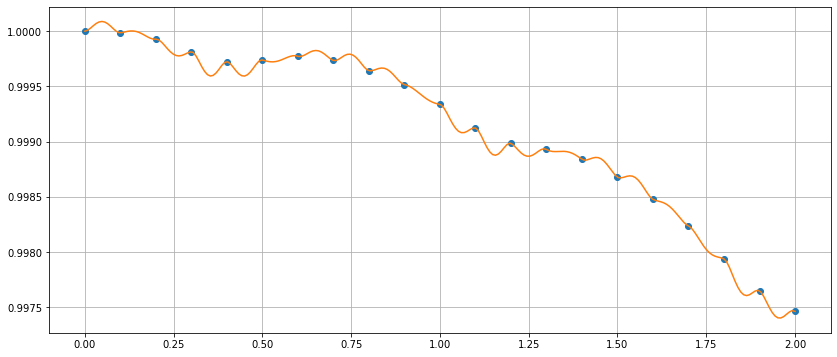

In [50]:
t_interp = np.linspace(0,2,250)
x_interp, u_interp = interpolated_array(
    x_arr,
    np.zeros([20,3]),
    0.1,
    t_interp,
    params,
    F=embudo,
    X_dot=None,
    scheme="hs_scipy",
    u_scheme="lin",
    scheme_params={},
)
q_interp = x_interp[:,:4]
plt.figure(figsize=[14,6])
plt.plot(np.linspace(0,2,21),np.sum(q_arr**2, axis = 1), 'o' )
plt.plot(t_interp, np.sum(q_interp**2, axis = 1))
plt.grid()

In [51]:
x_arr = integrate_hs(
    x_0=x0,
    u = np.zeros([20,3]),
    F = embudo,
    dt = 0.1,
    params=params
)
q_arr = x_arr[:,:4]
v_arr = x_arr[:,4:]

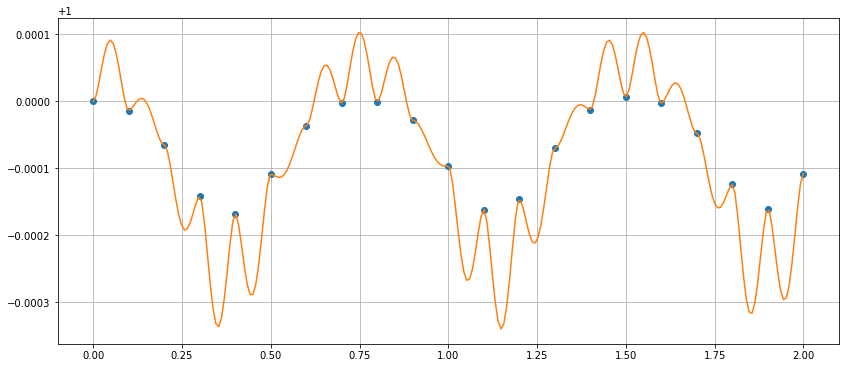

In [52]:
t_interp = np.linspace(0,2,250)
x_interp, u_interp = interpolated_array(
    x_arr,
    np.zeros([20,3]),
    0.1,
    t_interp,
    params,
    F=embudo,
    X_dot=None,
    scheme="hs",
    u_scheme="lin",
    scheme_params={},
)
q_interp = x_interp[:,:4]
plt.figure(figsize=[14,6])
plt.plot(np.linspace(0,2,21),np.sum(q_arr**2, axis = 1), 'o' )
plt.plot(t_interp, np.sum(q_interp**2, axis = 1))
plt.grid()

## Normalizando a cada paso

In [53]:
def normalize_x(x):
    x = np.array(x)
    q = x[:4]
    mod = np.sqrt(np.sum(q**2))
    q = q/mod
    x[:4] = q
    return x

In [54]:
@coherent_dimensions
def integrate_trapz_normalized(x_0, u, F, dt, params):
    x = [
        x_0,
    ]
    for ii in range(0, vec_len(u) - 1):
        x_i = trapz_step(x[-1], u[ii], u[ii + 1], F, dt, params)
        x_i = normalize_x(x_i)
        x.append(x_i)
    x_i = trapz_step(x[-1], u[-1], u[-1], F, dt, params)
    x_i = normalize_x(x_i)
    x.append(x_i)
    return np.array(x)

x_arr = integrate_trapz_normalized(
    x_0=x0,
    u = np.zeros([20,3]),
    F = embudo,
    dt = 0.1,
    params=params
)
q_arr = x_arr[:,:4]
v_arr = x_arr[:,4:]

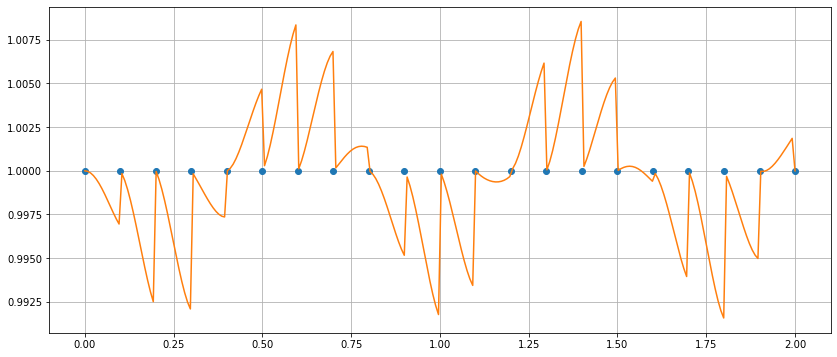

In [55]:
t_interp = np.linspace(0,2,250)
x_interp, u_interp = interpolated_array(
    x_arr,
    np.zeros([20,3]),
    0.1,
    t_interp,
    params,
    F=embudo,
    X_dot=None,
    scheme="trapz",
    u_scheme="lin",
    scheme_params={},
)
q_interp = x_interp[:,:4]
plt.figure(figsize=[14,6])
plt.plot(np.linspace(0,2,21),np.sum(q_arr**2, axis = 1), 'o' )
plt.plot(t_interp, np.sum(q_interp**2, axis = 1))
plt.grid()

In [56]:
@coherent_dimensions
def integrate_rk4_normalized(x_0, u, F, dt, params):
    x = [
        x_0,
    ]
    for ii in range(vec_len(u)):
        x_i = rk4_step(x[-1], u[ii], F, dt, params)
        x_i = normalize_x(x_i)
        x.append(x_i)
    return np.array(x)

x_arr = integrate_rk4_normalized(
    x_0=x0,
    u = np.zeros([20,3]),
    F = embudo,
    dt = 0.1,
    params=params
)
q_arr = x_arr[:,:4]
v_arr = x_arr[:,4:]

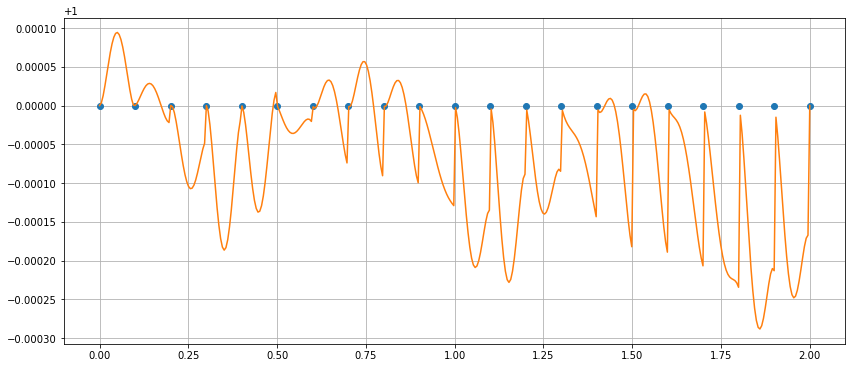

In [57]:
t_interp = np.linspace(0,2,400)
x_interp, u_interp = interpolated_array(
    x_arr,
    np.zeros([20,3]),
    0.1,
    t_interp,
    params,
    F=embudo,
    X_dot=None,
    scheme="hs",
    u_scheme="lin",
    scheme_params={},
)
q_interp = x_interp[:,:4]
plt.figure(figsize=[14,6])
plt.plot(np.linspace(0,2,21),np.sum(q_arr**2, axis = 1), 'o' )
plt.plot(t_interp, np.sum(q_interp**2, axis = 1))
plt.grid()

In [58]:
@coherent_dimensions
def integrate_hs_normalized(x_0, u, F, dt, params):
    x = [
        x_0,
    ]
    for ii in range(0, vec_len(u) - 1):
        x_i = hs_step(x[-1], u[ii], u[ii + 1], F, dt, params)
        x_i = normalize_x(x_i)
        x.append(x_i)
    x_i = hs_step(x[-1], u[-1], u[-1], F, dt, params)
    x_i = normalize_x(x_i)
    x.append(x_i)
    return np.array(x)


x_arr = integrate_hs_normalized(
    x_0=x0,
    u = np.zeros([20,3]),
    F = embudo,
    dt = 0.1,
    params=params
)
q_arr = x_arr[:,:4]
v_arr = x_arr[:,4:]

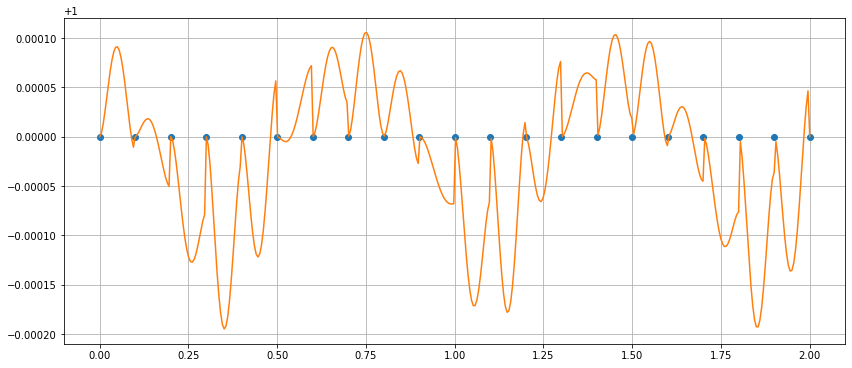

In [59]:
t_interp = np.linspace(0,2,400)
x_interp, u_interp = interpolated_array(
    x_arr,
    np.zeros([20,3]),
    0.1,
    t_interp,
    params,
    F=embudo,
    X_dot=None,
    scheme="hs",
    u_scheme="lin",
    scheme_params={},
)
q_interp = x_interp[:,:4]
plt.figure(figsize=[14,6])
plt.plot(np.linspace(0,2,21),np.sum(q_arr**2, axis = 1), 'o' )
plt.plot(t_interp, np.sum(q_interp**2, axis = 1))
plt.grid()

## New opti

In [60]:
from optibot.opti import Opti_Problem
import time

def sph_prob(scheme, N, ini_guess = 'lin', solve_repetitions = 1, t_end = 2, silent = False, ):
    _opti = Opti_Problem(
        LM=q_d_d_cas,
        params = params,
        scheme = scheme,
        ini_guess= ini_guess,
        t_end = t_end,
        silent= silent,
    )
    _opti.dynamic_setup()
    _opti.opti_setup(N)
    _opti.initial_guess([0,0], [1, np.pi])
    _opti.u_sq_cost()
    _opti.apply_scheme()
    
    X_s = _opti.opti_points['x_s']
    X_e = _opti.opti_points['x_e']

    _opti.opti.subject_to(X_s.T == [0,0,0,0])
    _opti.opti.subject_to(X_e.T == [1, np.pi,0,0])
    _opti.chrono_solve(solve_repetitions=solve_repetitions,)
    return _opti.results

_opti = Opti_Problem(
        LM=q_d_d_cas,
        params = params,
        scheme = 'trapz_mod',
        ini_guess= 'lin',
        t_end = 0.1,
        silent= False,
        verbose = True
    )

_opti.dynamic_setup(func_kind='g_q', n_q = 4, n_u = 3)
_opti.opti_setup(20)

q0 = quaternion(1, [1,2,0])
q1 = quaternion(1, [1,0,2])
_opti.initial_guess(q0,q1)

_opti.u_sq_cost()
_opti.apply_scheme()

q_s = _opti.opti_points['q_s']
v_s = _opti.opti_points['v_s']

_opti.opti.subject_to(q_s.T == q0)
_opti.opti.subject_to(v_s.T == 0)


q_e = _opti.opti_points['q_e']
v_e = _opti.opti_points['v_e']

_opti.opti.subject_to(q_e.T == q1)
_opti.opti.subject_to(v_e.T == 0)

U = _opti.opti_arrs['u']
#_opti.opti.subject_to(U == 0.5)

_opti.chrono_solve(solve_repetitions=1,)

plt.plot(_opti.opti.debug.value(_opti.opti_arrs['q']))

plt.plot(_opti.opti.debug.value(_opti.opti_arrs['u']))

## con c variable

In [61]:
_u_cvar = cas.SX.sym("u", 4)
_omega_d_cvar = _I_inv @ (_u_cvar[0:3] + _m*_g*_h* e3_x@R_cas_no_unit(_q).T@e3 - cross_mat_cas(_omega)@I_cas_diag(_I_diag_vals).T@_omega)

In [62]:
_q_d_d_cvar = 1/2*W_cas(_q_dot).T@_omega + 2*W_cas(_q).T@_omega_d_cvar + _u_cvar[3]*_q_dot

In [63]:
q_d_d_cas_cvar = cas.Function(
        "q_dot_dot",
        [_q, _q_dot, _u_cvar, _params],
        [_q_d_d_cvar],
        ["q", "q_d", "u", "params"],
        ["q_dot_dot"],
    )
q_d_d_cas_cvar.__name__ = q_d_d_cas_cvar.name()

In [64]:
N_step = 50
_opti = Opti_Problem(
        LM=q_d_d_cas_cvar,
        params = params,
        scheme = 'hs_mod',
        ini_guess= 'lin',
        t_end = 2,
        silent= False,
        verbose = True
    )

_opti.dynamic_setup(func_kind='g_q', n_q = 4, n_u = 4)
_opti.opti_setup(N_step)

q0 = quaternion(1, [1,2,0])
q1 = quaternion(1, [1,2,0])
_opti.initial_guess(q0,q1)

#_opti.u_sq_cost()

_opti.apply_scheme()


U = _opti.opti_arrs['u']
_opti.opti.subject_to(U[:,:3] == 0)

q_s = _opti.opti_points['q_s']
v_s = _opti.opti_points['v_s']
q_arr_cas = _opti.opti_arrs['q']

_opti.opti.subject_to(q_s.T == q0)
_opti.opti.subject_to(v_s.T == 0)

_opti.opti.subject_to(cas.sum2(q_arr_cas[1:,:]**2) == 1)

_opti.chrono_solve(solve_repetitions=1,)

Dynamics detected: Function

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    11221
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     5252

Total number of variables............................:     2020
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:   

  78  0.0000000e+00 1.29e+01 4.43e+04  -1.0 5.49e+04    -  1.00e+00 2.44e-04h 12
  79  0.0000000e+00 1.30e+01 4.43e+04  -1.0 3.80e+04    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  0.0000000e+00 1.30e+01 4.43e+04  -1.0 3.87e+04    -  1.00e+00 2.44e-04h 13
  81  0.0000000e+00 1.31e+01 4.42e+04  -1.0 3.93e+04    -  1.00e+00 2.44e-04h 13
  82  0.0000000e+00 1.31e+01 4.42e+04  -1.0 4.00e+04    -  1.00e+00 2.44e-04h 13
  83  0.0000000e+00 1.32e+01 4.42e+04  -1.0 4.07e+04    -  1.00e+00 2.44e-04h 13
  84  0.0000000e+00 1.33e+01 4.42e+04  -1.0 4.13e+04    -  1.00e+00 2.44e-04h 13
  85  0.0000000e+00 1.33e+01 4.42e+04  -1.0 4.20e+04    -  1.00e+00 2.44e-04h 13
  86  0.0000000e+00 1.34e+01 4.42e+04  -1.0 4.26e+04    -  1.00e+00 2.44e-04h 13
  87  0.0000000e+00 1.34e+01 4.41e+04  -1.0 4.32e+04    -  1.00e+00 2.44e-04h 13
  88  0.0000000e+00 1.03e+06 2.07e+09  -1.0 4.38e+04    -  1.00e+00 1.00e+00w  1
  89  0.0000000e+00 1.78e+06

 171  0.0000000e+00 5.77e+01 1.88e+05  -1.0 1.23e+05    -  1.00e+00 4.88e-04h 12
 172  0.0000000e+00 5.78e+01 1.88e+05  -1.0 1.28e+05    -  1.00e+00 2.44e-04h 13
 173  0.0000000e+00 5.78e+01 1.88e+05  -1.0 1.31e+05    -  1.00e+00 2.44e-04h 13
 174  0.0000000e+00 5.79e+01 1.88e+05  -1.0 1.33e+05    -  1.00e+00 2.44e-04h 13
 175  0.0000000e+00 5.79e+01 1.88e+05  -1.0 1.34e+05    -  1.00e+00 2.44e-04h 13
 176  0.0000000e+00 5.80e+01 1.88e+05  -1.0 1.36e+05    -  1.00e+00 2.44e-04h 13
 177  0.0000000e+00 5.80e+01 1.88e+05  -1.0 1.37e+05    -  1.00e+00 2.44e-04h 13
 178  0.0000000e+00 5.81e+01 1.88e+05  -1.0 1.37e+05    -  1.00e+00 2.44e-04h 13
 179  0.0000000e+00 1.10e+06 1.60e+09  -1.0 1.38e+05    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180  0.0000000e+00 7.70e+11 2.65e+18  -1.0 1.82e+08    -  1.00e+00 1.00e+00w  1
 181  0.0000000e+00 5.93e+10 7.12e+24  -1.0 3.39e+05  19.3 1.00e+00 1.00e+00w  1
 182  0.0000000e+00 5.81e+01

 272  0.0000000e+00 3.95e+05 2.10e+17  -1.0 3.35e+01  15.8 1.00e+00 1.00e+00w  1
 273  0.0000000e+00 5.14e+01 1.06e+07  -1.0 1.81e+01  16.2 1.00e+00 2.44e-04h 12
 274  0.0000000e+00 5.15e+01 1.06e+07  -1.0 1.11e+05    -  1.00e+00 2.44e-04h 13
 275  0.0000000e+00 5.15e+01 1.06e+07  -1.0 1.12e+05    -  1.00e+00 2.44e-04h 13
 276  0.0000000e+00 5.15e+01 1.06e+07  -1.0 1.13e+05    -  1.00e+00 2.44e-04h 13
 277  0.0000000e+00 5.15e+01 1.06e+07  -1.0 1.14e+05    -  1.00e+00 2.44e-04h 13
 278  0.0000000e+00 5.15e+01 1.06e+07  -1.0 1.15e+05    -  1.00e+00 1.22e-04h 14
 279  0.0000000e+00 5.15e+01 1.06e+07  -1.0 1.16e+05    -  1.00e+00 1.22e-04h 14
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280  0.0000000e+00 5.15e+01 1.06e+07  -1.0 1.16e+05    -  1.00e+00 1.22e-04h 14
 281  0.0000000e+00 5.15e+01 1.06e+07  -1.0 1.17e+05    -  1.00e+00 1.22e-04h 14
 282  0.0000000e+00 5.15e+01 1.06e+07  -1.0 1.18e+05    -  1.00e+00 1.22e-04h 14
 283  0.0000000e+00 5.40e+05

 366  0.0000000e+00 5.18e+01 1.05e+07  -1.0 1.74e+05    -  1.00e+00 6.10e-05h 15
 367  0.0000000e+00 5.18e+01 1.05e+07  -1.0 1.74e+05    -  1.00e+00 6.10e-05h 15
 368  0.0000000e+00 5.18e+01 1.05e+07  -1.0 1.75e+05    -  1.00e+00 6.10e-05h 15
 369  0.0000000e+00 5.18e+01 1.05e+07  -1.0 1.76e+05    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 370  0.0000000e+00 5.18e+01 1.05e+07  -1.0 1.77e+05    -  1.00e+00 6.10e-05h 15
 371  0.0000000e+00 5.18e+01 1.05e+07  -1.0 1.78e+05    -  1.00e+00 6.10e-05h 15
 372  0.0000000e+00 5.18e+01 1.05e+07  -1.0 1.78e+05    -  1.00e+00 6.10e-05h 15
 373  0.0000000e+00 5.18e+01 1.05e+07  -1.0 1.79e+05    -  1.00e+00 6.10e-05h 15
 374  0.0000000e+00 1.42e+06 2.01e+09  -1.0 1.80e+05    -  1.00e+00 1.00e+00w  1
 375  0.0000000e+00 1.42e+06 6.53e+17  -1.0 1.99e+00  17.5 1.00e+00 1.00e+00w  1
 376  0.0000000e+00 1.91e+06 2.65e+21  -1.0 8.82e+04    -  1.00e+00 1.00e+00w  1
 377  0.0000000e+00 5.18e+01

 467  0.0000000e+00 6.03e+05 1.18e+18  -1.0 6.59e+02  15.3 1.00e+00 1.00e+00w  1
 468  0.0000000e+00 5.20e+01 1.05e+07  -1.0 9.14e+01  15.7 1.00e+00 3.05e-05h 15
 469  0.0000000e+00 5.20e+01 1.05e+07  -1.0 2.65e+05    -  1.00e+00 3.05e-05h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 470  0.0000000e+00 5.20e+01 1.05e+07  -1.0 2.66e+05    -  1.00e+00 3.05e-05h 16
 471  0.0000000e+00 5.20e+01 1.05e+07  -1.0 2.67e+05    -  1.00e+00 3.05e-05h 16
 472  0.0000000e+00 5.20e+01 1.05e+07  -1.0 2.69e+05    -  1.00e+00 3.05e-05h 16
 473  0.0000000e+00 5.20e+01 1.05e+07  -1.0 2.70e+05    -  1.00e+00 3.05e-05h 16
 474  0.0000000e+00 5.20e+01 1.05e+07  -1.0 2.71e+05    -  1.00e+00 3.05e-05h 16
 475  0.0000000e+00 5.20e+01 1.05e+07  -1.0 2.72e+05    -  1.00e+00 3.05e-05h 16
 476  0.0000000e+00 5.20e+01 1.05e+07  -1.0 2.74e+05    -  1.00e+00 3.05e-05h 16
 477  0.0000000e+00 5.20e+01 1.05e+07  -1.0 2.75e+05    -  1.00e+00 3.05e-05h 16
 478  0.0000000e+00 3.81e+06

 565  0.0000000e+00 3.98e-01 1.94e+10  -1.7 4.94e-06  15.6 1.00e+00 1.00e+00h  1
 566  0.0000000e+00 3.99e-01 2.82e+10  -1.7 2.15e-05  15.1 1.00e+00 1.00e+00h  1
 567  0.0000000e+00 3.95e-01 1.16e+19  -1.7 4.90e+02  14.6 1.00e+00 7.81e-03h  8
 568  0.0000000e+00 3.95e-01 1.08e+19  -1.7 1.37e+04    -  1.00e+00 4.88e-04h 12
 569  0.0000000e+00 3.95e-01 1.09e+19  -1.7 1.64e+04    -  1.00e+00 2.44e-04h 13
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 570  0.0000000e+00 3.95e-01 1.14e+19  -1.7 1.67e+04    -  1.00e+00 4.88e-04h 12
 571  0.0000000e+00 3.95e-01 1.45e+19  -1.7 1.70e+04    -  1.00e+00 9.77e-04h 11
 572  0.0000000e+00 3.94e-01 1.85e+19  -1.7 1.78e+04    -  1.00e+00 9.77e-04h 11
 573  0.0000000e+00 3.94e-01 1.92e+19  -1.7 1.87e+04    -  1.00e+00 4.88e-04h 12
 574  0.0000000e+00 3.94e-01 1.94e+19  -1.7 1.92e+04    -  1.00e+00 2.44e-04h 13
 575  0.0000000e+00 3.94e-01 1.94e+19  -1.7 1.95e+04    -  1.00e+00 6.10e-05h 15
 576  0.0000000e+00 3.94e-01

 661  0.0000000e+00 3.92e-01 2.00e+19  -1.7 2.09e+06  20.0 1.00e+00 6.10e-05h 15
 662  0.0000000e+00 3.92e-01 2.00e+19  -1.7 2.68e+04    -  1.00e+00 6.10e-05h 15
 663  0.0000000e+00 3.92e-01 2.00e+19  -1.7 2.69e+04    -  1.00e+00 6.10e-05h 15
 664  0.0000000e+00 3.92e-01 2.00e+19  -1.7 2.71e+04    -  1.00e+00 6.10e-05h 15
 665  0.0000000e+00 3.92e-01 2.00e+19  -1.7 2.72e+04    -  1.00e+00 6.10e-05h 15
 666  0.0000000e+00 3.92e-01 2.00e+19  -1.7 2.74e+04    -  1.00e+00 6.10e-05h 15
 667  0.0000000e+00 3.92e-01 2.00e+19  -1.7 2.75e+04    -  1.00e+00 6.10e-05h 15
 668  0.0000000e+00 3.92e-01 2.01e+19  -1.7 2.77e+04    -  1.00e+00 6.10e-05h 15
 669  0.0000000e+00 3.92e-01 2.01e+19  -1.7 2.79e+04    -  1.00e+00 6.10e-05h 15
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 670  0.0000000e+00 3.92e-01 2.01e+19  -1.7 2.80e+04    -  1.00e+00 6.10e-05h 15
 671  0.0000000e+00 9.05e+04 2.75e+24  -1.7 2.82e+04    -  1.00e+00 1.00e+00w  1
 672  0.0000000e+00 3.92e-01

 749  0.0000000e+00 3.91e-01 2.02e+19  -1.7 3.77e+04  20.0 1.00e+00 3.05e-05h 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 750  0.0000000e+00 3.91e-01 2.02e+19  -1.7 3.78e+04    -  1.00e+00 3.05e-05h 16
 751  0.0000000e+00 3.91e-01 2.02e+19  -1.7 3.80e+04    -  1.00e+00 3.05e-05h 16
 752  0.0000000e+00 3.91e-01 2.02e+19  -1.7 3.82e+04    -  1.00e+00 3.05e-05h 16
 753  0.0000000e+00 3.91e-01 2.02e+19  -1.7 3.84e+04    -  1.00e+00 3.05e-05h 16
 754  0.0000000e+00 3.91e-01 2.02e+19  -1.7 3.86e+04    -  1.00e+00 3.05e-05h 16
 755  0.0000000e+00 3.91e-01 2.02e+19  -1.7 3.88e+04    -  1.00e+00 3.05e-05h 16
 756  0.0000000e+00 3.91e-01 2.02e+19  -1.7 3.90e+04    -  1.00e+00 3.05e-05h 16
 757  0.0000000e+00 3.91e-01 2.02e+19  -1.7 3.91e+04    -  1.00e+00 3.05e-05h 16
 758  0.0000000e+00 3.91e-01 2.03e+19  -1.7 3.93e+04    -  1.00e+00 3.05e-05h 16
 759  0.0000000e+00 1.41e+05 3.00e+24  -1.7 3.95e+04    -  1.00e+00 1.00e+00w  1
iter    objective    inf_pr 

 841  0.0000000e+00 2.09e-01 5.00e+09  -1.7 6.95e+03    -  1.00e+00 9.77e-04h 11
 842  0.0000000e+00 2.09e-01 4.99e+09  -1.7 7.32e-07  15.8 1.00e+00 1.00e+00h  1
 843r 0.0000000e+00 2.09e-01 9.99e+02  -0.7 0.00e+00    -  0.00e+00 4.77e-07R 22
 844r 0.0000000e+00 1.47e-01 9.90e+02  -0.7 5.24e+03    -  1.21e-01 6.04e-03f  1
 845  0.0000000e+00 1.47e-01 3.28e+09  -2.5 1.44e-06  15.4 1.00e+00 1.00e+00h  1
 846  0.0000000e+00 1.47e-01 6.45e+09  -2.5 8.52e-06  14.9 1.00e+00 1.00e+00h  1
 847  0.0000000e+00 1.47e-01 9.21e+09  -2.5 3.65e-05  14.4 1.00e+00 1.00e+00h  1
 848  0.0000000e+00 1.47e-01 1.05e+10  -2.5 1.25e-04  13.9 1.00e+00 1.00e+00h  1
 849  0.0000000e+00 1.47e-01 8.23e+09  -2.5 2.93e-04  13.4 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 850  0.0000000e+00 1.47e-01 2.55e+09  -2.5 2.73e-04  13.0 1.00e+00 1.00e+00h  1
 851  0.0000000e+00 1.47e-01 2.37e+09  -2.5 7.60e-04  12.5 1.00e+00 1.00e+00h  1
 852  0.0000000e+00 1.47e-01

 943r 0.0000000e+00 7.41e+00 1.09e+01  -2.6 7.92e+01    -  1.00e+00 1.00e+00f  1
 944r 0.0000000e+00 1.41e-01 1.10e-02  -2.6 8.99e+00    -  1.00e+00 1.00e+00h  1
 945r 0.0000000e+00 2.50e-03 3.10e-05  -2.6 5.46e-02    -  1.00e+00 1.00e+00h  1
 946r 0.0000000e+00 2.50e-03 9.99e+02  -2.6 0.00e+00    -  0.00e+00 4.77e-07R 22
 947r 0.0000000e+00 4.61e+00 1.24e+02  -2.6 7.09e+01    -  1.00e+00 8.76e-01f  1
 948r 0.0000000e+00 2.26e-03 2.20e-01  -2.6 1.25e+00    -  1.00e+00 1.00e+00h  1
 949r 0.0000000e+00 2.26e-03 1.04e-05  -2.6 9.56e-03    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 950r 0.0000000e+00 2.25e-03 9.01e+01  -5.9 4.85e-01    -  5.56e-01 7.70e-01f  1
 951r 0.0000000e+00 3.69e-03 1.03e+02  -5.9 5.57e-01  -2.0 5.34e-01 6.38e-01f  1
 952r 0.0000000e+00 2.37e-02 3.51e+01  -5.9 1.47e+00  -2.5 7.22e-01 6.60e-01f  1
 953r 0.0000000e+00 4.24e-02 3.63e+01  -5.9 3.67e+00  -3.0 3.69e-01 4.15e-01h  1
 954r 0.0000000e+00 5.33e-02

1036r 0.0000000e+00 8.80e-01 6.44e+02  -7.6 1.79e+01  -4.3 1.00e+00 1.13e-01h  1
1037r 0.0000000e+00 5.79e-01 7.40e+02  -7.6 5.71e+01  -4.8 1.00e+00 4.11e-01h  1
1038r 0.0000000e+00 5.22e-01 4.20e+02  -7.6 1.19e+02  -5.3 2.02e-02 1.02e-01h  1
1039r 0.0000000e+00 2.75e+00 2.97e+02  -7.6 8.42e+02  -5.8 2.36e-02 7.13e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1040r 0.0000000e+00 2.66e+00 3.66e+02  -7.6 1.64e+02  -5.3 1.22e-01 3.07e-02h  1
1041r 0.0000000e+00 2.81e+00 3.59e+02  -7.6 4.35e+03  -5.8 3.29e-04 3.00e-03h  1
1042r 0.0000000e+00 2.80e+00 3.41e+02  -7.6 5.70e+00  -3.6 5.23e-03 9.68e-04h  1
1043r 0.0000000e+00 2.76e+00 2.94e+02  -7.6 2.40e+00  -3.2 2.67e-02 1.48e-02f  1
1044r 0.0000000e+00 2.76e+00 2.84e+02  -7.6 2.96e+00  -3.6 1.70e-02 2.21e-03h  1
1045r 0.0000000e+00 2.75e+00 8.31e+02  -7.6 2.50e+00  -3.2 5.03e-02 2.13e-03h  1
1046r 0.0000000e+00 2.37e+00 7.17e+02  -7.6 3.10e+00  -3.7 3.36e-02 1.37e-01h  1
1047r 0.0000000e+00 2.37e+00

1133r 0.0000000e+00 6.17e-01 6.87e+02  -7.6 1.60e+01  -4.8 4.03e-01 8.03e-04f  1
1134r 0.0000000e+00 5.95e-01 5.25e+02  -7.6 9.75e+01    -  9.58e-04 6.02e-02h  1
1135r 0.0000000e+00 2.74e-01 2.69e+02  -7.6 6.09e+00  -4.4 8.44e-01 5.54e-01h  1
1136r 0.0000000e+00 2.58e-01 8.42e+02  -7.6 6.71e+01    -  1.00e+00 6.58e-02h  1
1137r 0.0000000e+00 5.77e+00 1.98e+02  -7.6 6.37e+01    -  1.00e+00 7.74e-01h  1
1138r 0.0000000e+00 4.73e+00 1.86e+02  -7.6 1.64e+00  -4.0 8.42e-02 1.80e-01h  1
1139r 0.0000000e+00 4.68e+00 5.02e+02  -7.6 1.90e+00  -4.5 3.13e-01 1.08e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1140r 0.0000000e+00 4.68e+00 4.99e+02  -7.6 3.51e+01  -4.9 4.06e-03 5.71e-04h  1
1141r 0.0000000e+00 4.41e+00 1.27e+03  -7.6 1.89e+00  -4.5 1.33e-01 5.66e-02h  1
1142r 0.0000000e+00 4.26e+00 1.25e+03  -7.6 4.27e+00  -5.0 2.08e-02 3.51e-02h  1
1143r 0.0000000e+00 3.02e+00 8.95e+02  -7.6 5.48e+00  -5.5 9.27e-02 2.90e-01h  1
1144r 0.0000000e+00 2.95e+00

1228r 0.0000000e+00 2.98e-03 9.82e+02 -11.3 1.29e+00  -4.2 1.00e+00 1.06e-01h  1
1229r 0.0000000e+00 4.85e-02 7.96e+02 -11.3 3.41e+00  -4.7 1.00e+00 4.81e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1230r 0.0000000e+00 4.63e-02 7.24e+02 -11.3 1.13e+00  -4.3 3.01e-01 4.58e-02h  1
1231r 0.0000000e+00 3.60e-02 5.68e+02 -11.3 4.29e-01  -3.8 1.00e+00 2.30e-01h  1
1232r 0.0000000e+00 3.56e-02 5.85e+02 -11.3 1.23e+00  -4.3 7.12e-02 1.03e-02h  1
1233r 0.0000000e+00 3.45e-02 6.65e+02 -11.3 4.98e-01  -3.9 2.26e-01 2.99e-02h  1
1234r 0.0000000e+00 3.45e-02 6.62e+02 -11.3 1.39e+00  -4.4 1.45e-01 1.54e-05h  1
1235r 0.0000000e+00 2.62e-02 9.29e+02 -11.3 5.78e-01  -3.9 1.00e+00 2.56e-01h  1
1236r 0.0000000e+00 2.55e-02 1.28e+03 -11.3 1.61e+00  -4.4 1.00e+00 2.69e-02h  1
1237r 0.0000000e+00 2.24e-02 1.21e+03 -11.3 7.12e-01  -4.0 4.90e-01 1.27e-01h  1
1238r 0.0000000e+00 2.24e-02 1.44e+03 -11.3 1.92e+00  -4.5 0.00e+00 1.06e-08R  6
1239r 0.0000000e+00 2.24e-02

1321r 0.0000000e+00 1.55e-02 2.44e+04 -11.3 2.31e-01  -3.4 5.71e-03 3.81e-01h  1
1322r 0.0000000e+00 1.33e-02 2.01e+04 -11.3 3.95e-01  -3.9 1.76e-01 1.40e-01h  1
1323r 0.0000000e+00 1.29e-02 1.93e+04 -11.3 4.49e+00  -4.4 3.83e-02 3.03e-02h  4
1324r 0.0000000e+00 1.21e-02 7.68e+03 -11.3 3.93e-01  -4.0 6.13e-01 5.88e-02h  1
1325r 0.0000000e+00 2.57e-03 2.32e+03 -11.3 2.33e-01  -3.5 6.97e-01 7.91e-01h  1
1326r 0.0000000e+00 2.57e-03 2.27e+03 -11.3 7.13e-01  -4.0 7.30e-02 5.51e-04h  1
1327r 0.0000000e+00 2.10e-03 4.13e+03 -11.3 2.73e-01  -3.6 7.99e-01 1.84e-01h  1
1328r 0.0000000e+00 2.10e-03 7.13e+03 -11.3 7.61e-01  -4.1 1.15e-01 7.66e-05h  1
1329r 0.0000000e+00 1.41e-03 4.87e+03 -11.3 2.20e-01  -3.6 3.20e-01 3.36e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1330r 0.0000000e+00 1.41e-03 2.75e+03 -11.3 6.88e-01  -4.1 3.91e-01 1.67e-03h  1
1331r 0.0000000e+00 1.18e-03 2.96e+03 -11.3 2.33e-01  -3.7 1.25e-03 1.67e-01h  1
1332r 0.0000000e+00 1.17e-03

1429r 0.0000000e+00 4.16e-04 6.99e+03 -11.3 5.92e-01  -3.5 1.01e-02 4.46e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1430r 0.0000000e+00 4.28e-04 6.79e+03 -11.3 2.71e+01  -4.0 6.61e-02 5.83e-03h  1
1431r 0.0000000e+00 4.24e-04 1.01e+04 -11.3 6.09e-01  -3.5 2.40e-01 9.95e-03h  1
1432r 0.0000000e+00 6.02e-03 9.89e+03 -11.3 3.28e+00  -4.0 2.27e-02 9.81e-02h  1
1433r 0.0000000e+00 5.90e-03 9.45e+03 -11.3 3.71e+00  -4.5 4.88e-02 1.77e-02h  1
1434r 0.0000000e+00 4.17e-03 8.88e+03 -11.3 1.53e+00  -4.1 1.62e-02 2.97e-01h  1
1435r 0.0000000e+00 4.12e-03 7.09e+03 -11.3 4.21e+00  -4.5 2.28e-01 1.42e-02h  1
1436r 0.0000000e+00 3.97e-03 6.90e+03 -11.3 1.70e+00  -4.1 1.76e-02 7.78e-02h  1
1437r 0.0000000e+00 3.95e-03 6.62e+03 -11.3 2.30e+00  -4.6 4.61e-02 5.46e-03h  1
1438r 0.0000000e+00 3.84e-03 6.06e+03 -11.3 8.20e-01  -4.2 9.86e-02 3.87e-02h  1
1439r 0.0000000e+00 1.27e-02 5.83e+03 -11.3 7.40e+00  -4.6 8.61e-03 1.59e-01h  1
iter    objective    inf_pr 

1521r 0.0000000e+00 9.46e-03 3.08e+04 -11.3 2.01e+00  -4.0 3.39e-01 1.02e-03h  1
1522r 0.0000000e+00 1.35e-02 2.27e+04 -11.3 1.84e+01  -4.5 2.70e-01 7.04e-02h  1
1523r 0.0000000e+00 1.30e-02 2.26e+04 -11.3 9.76e+00  -5.0 5.75e-03 4.57e-02h  1
1524r 0.0000000e+00 1.29e-02 2.57e+03 -11.3 4.42e-01  -4.6 9.24e-01 5.30e-03h  1
1525r 0.0000000e+00 2.33e-03 3.99e+03 -11.3 5.47e-01  -4.1 1.00e+00 8.31e-01h  1
1526r 0.0000000e+00 2.18e-03 3.39e+03 -11.3 5.05e-01  -4.6 1.53e-01 6.32e-02h  1
1527r 0.0000000e+00 4.13e-03 4.86e+03 -11.3 2.38e+00  -5.1 2.81e-01 2.38e-01h  1
1528r 0.0000000e+00 4.01e-03 3.17e+03 -11.3 1.25e+00  -4.7 4.58e-01 3.03e-02h  1
1529r 0.0000000e+00 1.17e-03 1.73e+03 -11.3 2.89e-01  -4.2 3.38e-01 9.55e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1530r 0.0000000e+00 2.05e-03 1.01e+04 -11.3 8.99e-01  -4.7 4.48e-02 3.87e-01h  1
1531r 0.0000000e+00 8.94e-04 2.53e+03 -11.3 2.97e-01  -4.3 7.36e-01 1.00e+00h  1
1532r 0.0000000e+00 7.73e-04

1628r 0.0000000e+00 2.24e-03 1.09e+04 -11.3 5.42e+01  -4.0 1.50e-05 6.94e-04f  1
1629r 0.0000000e+00 2.24e-03 1.09e+04 -11.3 8.59e+01  -4.5 1.30e-03 2.44e-04f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1630r 0.0000000e+00 2.17e-03 1.09e+04 -11.3 5.19e+01  -4.1 1.96e-04 7.21e-04f  1
1631r 0.0000000e+00 2.18e-03 1.06e+04 -11.3 1.45e+02  -4.6 2.23e-02 1.36e-04f  3
1632r 0.0000000e+00 2.17e-03 1.05e+04 -11.3 5.25e+01  -4.1 1.12e-03 4.97e-05f  5
1633r 0.0000000e+00 2.17e-03 1.04e+04 -11.3 4.09e+02  -4.6 1.01e-02 3.97e-06f  6
In iteration 1633, 1 Slack too small, adjusting variable bound
1634r 0.0000000e+00 2.17e-03 1.04e+04 -11.3 5.00e+01  -4.2 1.38e-03 6.21e-10f  1
1635r 0.0000000e+00 2.17e-03 1.04e+04 -11.3 4.97e+01  -3.8 5.64e-04 4.88e-05f  5
1636r 0.0000000e+00 2.16e-03 1.04e+04 -11.3 5.17e+01  -4.2 2.59e-03 2.28e-05f  6
1637r 0.0000000e+00 2.16e-03 1.04e+04 -11.3 5.13e+01  -3.8 7.40e-05 2.54e-05f  6
1638r 0.0000000e+00 2.16e-03 1.04e+04 -11.3 5.

1721r 0.0000000e+00 4.68e-04 1.73e+03 -11.3 7.56e-01  -4.1 1.82e-01 1.97e-02h  1
1722r 0.0000000e+00 4.14e-04 1.37e+03 -11.3 3.38e-01  -3.7 6.93e-04 1.50e-01h  1
1723r 0.0000000e+00 4.14e-04 1.50e+03 -11.3 8.80e-01  -4.2 1.29e-01 1.54e-04h  1
1724r 0.0000000e+00 3.75e-04 1.31e+03 -11.3 3.61e-01  -3.8 1.37e-01 1.33e-01h  1
1725r 0.0000000e+00 3.73e-04 1.89e+04 -11.3 7.69e-01  -4.2 1.19e-01 6.15e-03h  1
1726r 0.0000000e+00 3.62e-04 1.51e+04 -11.3 3.87e-01  -3.8 2.03e-01 3.38e-02h  1
1727r 0.0000000e+00 3.62e-04 2.37e+04 -11.3 8.23e-01  -4.3 6.19e-01 6.97e-07h  1
1728r 0.0000000e+00 9.82e-04 1.44e+04 -11.3 3.01e+00  -4.8 4.15e-01 1.31e-01h  1
1729r 0.0000000e+00 9.81e-04 1.41e+04 -11.3 5.55e-01  -4.3 2.32e-02 8.78e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1730r 0.0000000e+00 9.80e-04 1.07e+04 -11.3 2.11e-01  -3.9 2.67e-01 4.93e-04h  1
1731r 0.0000000e+00 9.34e-04 9.20e+03 -11.3 1.15e+00  -4.4 1.20e-01 2.71e-01h  1
1732r 0.0000000e+00 9.33e-04

1824r 0.0000000e+00 1.45e-03 4.20e+03 -11.3 1.49e+01  -4.5 2.50e-03 1.39e-03f  1
1825r 0.0000000e+00 1.42e-03 4.21e+03 -11.3 1.55e+01  -5.0 1.49e-03 7.21e-04f  2
1826r 0.0000000e+00 1.38e-03 4.37e+03 -11.3 1.46e+01  -4.6 1.14e-02 7.46e-04f  1
1827r 0.0000000e+00 1.38e-03 4.41e+03 -11.3 1.92e+01  -5.0 3.01e-03 2.03e-04f  7
1828r 0.0000000e+00 1.36e-03 4.49e+03 -11.3 1.22e+01  -4.6 4.50e-03 3.68e-04f  6
1829r 0.0000000e+00 1.35e-03 4.57e+03 -11.3 1.97e+01  -5.1 6.75e-03 1.92e-04f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1830r 0.0000000e+00 1.35e-03 4.58e+03 -11.3 1.27e+01  -4.7 4.54e-04 4.38e-05f  9
1831r 0.0000000e+00 1.35e-03 4.86e+03 -11.3 2.27e+01  -5.2 2.69e-02 2.39e-05f 10
1832r 0.0000000e+00 8.83e-04 4.85e+03 -11.3 1.58e+01  -4.7 6.31e-04 1.05e-02f  1
1833r 0.0000000e+00 7.33e-04 4.83e+03 -11.3 1.13e+01  -4.3 1.22e-03 5.47e-03f  1
1834r 0.0000000e+00 7.02e-04 4.80e+03 -11.3 1.41e+01  -4.8 1.26e-02 1.42e-03f  1
1835r 0.0000000e+00 5.85e-04

1927r 0.0000000e+00 1.82e-03 4.15e+03 -11.3 3.83e-02  -2.2 5.39e-01 5.11e-02f  1
1928r 0.0000000e+00 1.81e-03 2.22e+03 -11.3 1.16e-01  -2.7 4.23e-01 6.26e-03h  1
1929r 0.0000000e+00 1.72e-03 1.79e+03 -11.3 5.09e-02  -2.2 2.87e-01 4.82e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1930r 0.0000000e+00 1.43e-03 1.49e+03 -11.3 1.39e-01  -2.7 1.69e-01 1.72e-01f  1
1931r 0.0000000e+00 9.80e-04 2.19e+04 -11.3 5.85e-02  -2.3 1.59e-01 3.13e-01f  1
1932r 0.0000000e+00 8.05e-04 1.59e+04 -11.3 1.43e-01  -2.8 2.79e-01 1.75e-01f  1
1933r 0.0000000e+00 6.91e-04 4.73e+03 -11.3 2.62e-01  -3.2 6.78e-01 1.34e-01f  1
1934r 0.0000000e+00 5.75e-04 3.57e+03 -11.3 1.29e-01  -2.8 2.54e-01 1.66e-01f  1
1935r 0.0000000e+00 4.56e-04 2.99e+03 -11.3 3.24e-01  -3.3 1.72e-01 2.68e-01f  1
1936r 0.0000000e+00 3.77e-04 2.76e+03 -11.3 1.16e-01  -2.9 8.51e-02 1.76e-01h  1
1937r 0.0000000e+00 3.63e-04 2.54e+03 -11.3 3.53e-01  -3.3 7.65e-02 3.80e-02h  1
1938r 0.0000000e+00 3.60e-04

2022r 0.0000000e+00 8.22e-04 1.21e+04 -11.3 1.99e-01  -3.1 1.55e-02 2.89e-02h  1
2023r 0.0000000e+00 8.22e-04 1.61e+03 -11.3 5.04e-01  -3.6 9.00e-01 2.65e-04h  1
2024r 0.0000000e+00 4.99e-04 1.27e+03 -11.3 2.99e-01  -3.2 1.07e-01 4.08e-01h  1
2025r 0.0000000e+00 4.98e-04 1.27e+03 -11.3 5.84e-01  -3.6 2.34e-03 1.52e-03h  1
2026r 0.0000000e+00 4.84e-04 1.22e+03 -11.3 2.21e-01  -3.2 3.89e-02 2.86e-02h  1
2027r 0.0000000e+00 4.84e-04 1.49e+03 -11.3 6.57e-01  -3.7 1.62e-01 8.06e-06h  1
2028r 0.0000000e+00 3.68e-04 1.31e+03 -11.3 2.43e-01  -3.3 1.05e-01 2.93e-01h  1
2029r 0.0000000e+00 3.68e-04 1.45e+03 -11.3 7.34e-01  -3.7 1.80e-01 3.87e-06h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2030r 0.0000000e+00 2.94e-04 2.19e+04 -11.3 3.55e-01  -3.3 1.26e-01 2.73e-01h  1
2031r 0.0000000e+00 3.04e-04 1.83e+04 -11.3 9.64e-01  -3.8 1.73e-01 8.08e-02h  1
2032r 0.0000000e+00 2.87e-04 1.49e+04 -11.3 4.27e-01  -3.4 1.99e-01 8.66e-02h  1
2033r 0.0000000e+00 2.85e-04

In [65]:
%matplotlib inline

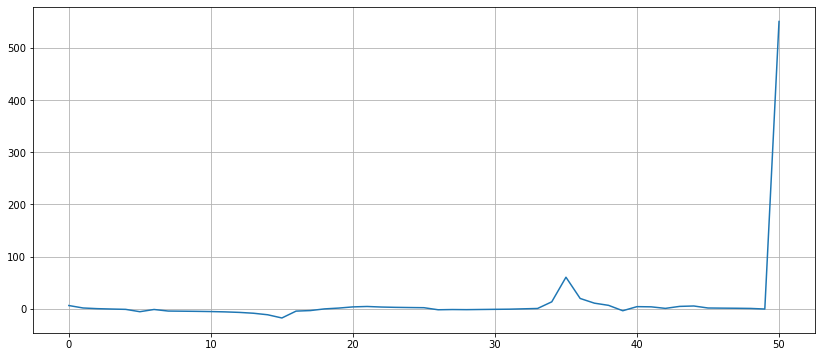

In [66]:
plt.figure(figsize=[14,6])
plt.plot(_opti.results['u'][:,-1])
plt.grid()

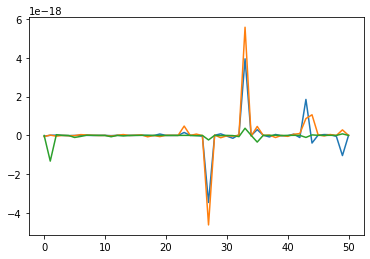

In [67]:
plt.plot(_opti.results['u'][:,:-1])

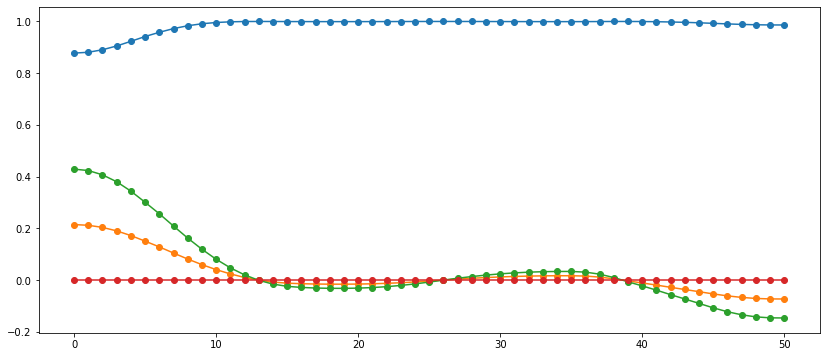

In [68]:
plt.figure(figsize=[14,6])
plt.plot(_opti.results['q'], marker = 'o')

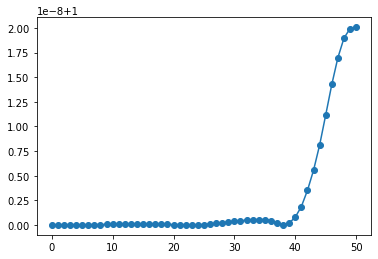

In [69]:
plt.plot(np.sum(_opti.results['q']**2, axis=1), marker = 'o')

In [70]:
x_d_cas_cvar = expand_G(q_d_d_cas_cvar, 'casadi')
def embudo_cvar(x, u, p):
    sol = x_d_cas_cvar(x,u,p)
    sol = np.array(sol).flatten()
    return sol

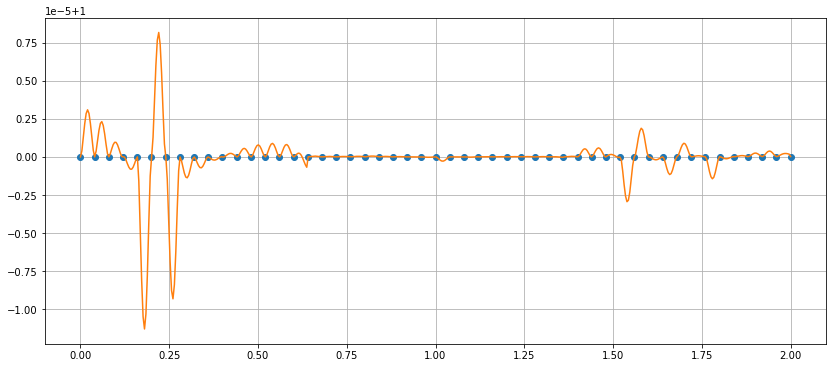

In [71]:
nn = _opti.results['x'].shape[0]
t_interp = np.linspace(0,2,500)
x_interp, u_interp = interpolated_array(
    _opti.results['x'],
    _opti.results['u'],
    2/(nn-1),
    t_interp,
    params,
    F=embudo_cvar,
    X_dot=None,
    scheme="hs",
    u_scheme="lin",
    scheme_params={},
)
q_interp = x_interp[:,:4]
plt.figure(figsize=[14,6])
plt.plot(np.linspace(0,2,nn),np.sum(_opti.results['q']**2, axis = 1), 'o' )
plt.plot(t_interp, np.sum(q_interp**2, axis = 1))
plt.grid()

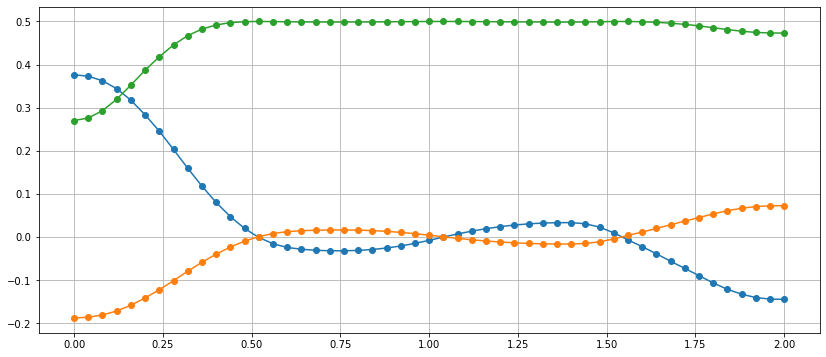

In [72]:
plt.figure(figsize=[14,6])
q_arr = _opti.results['q']
cart_arr = quat_to_cart_arr(q_arr)
plt.plot(np.linspace(0,2,51),cart_arr, marker='o')
plt.grid()

In [73]:
%matplotlib notebook

<IPython.core.display.Javascript object>


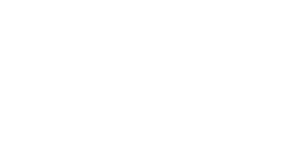

In [74]:
ax = plt.axes(projection='3d')

ax.plot3D(cart_arr[:,0], cart_arr[:,1], cart_arr[:,2], 'gray', marker = 'o')

In [75]:
%matplotlib inline